In [181]:
import torch
import torchvision

from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
print(f"Default device set to {device}")

Default device set to cuda


In [182]:
train_data = torchvision.datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

test_data = torchvision.datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

In [183]:
import matplotlib.pyplot as plt

In [184]:
print(train_data[0][0].shape) #1 channel, 28px by 28px
label = train_data[0][1]



def plot_samples(rows, columns, idx):
    figure, axis = plt.subplots(rows, columns)
    figure.tight_layout()
    for r in range(rows):
        for c in range(columns):
            axis[r][c].imshow(train_data[idx][0].view(28, 28, 1), cmap="grey") #Either squeeze or use view, matplotlib expectes color channels as the last dimension; because it's gray scale it does not matter if the color channel is removed
            axis[r][c].set(xlabel=train_data.classes[train_data[idx][1]])
            idx += 1



def plot_random_samples(rows, columns, data):
    samples_idx = torch.randint(0, len(data), (rows, columns))
    figure, axis = plt.subplots(rows, columns)
    figure.tight_layout()
    for r in range(rows):
        for c in range(columns):
            axis[r][c].imshow(data[samples_idx[r, c]][0].view(28, 28, 1), cmap="grey") #Either squeeze or use view, matplotlib expectes color channels as the last dimension; because it's gray scale it does not matter if the color channel is removed
            axis[r][c].set(xlabel=train_data.classes[train_data[samples_idx[r, c]][1]])





torch.Size([1, 28, 28])


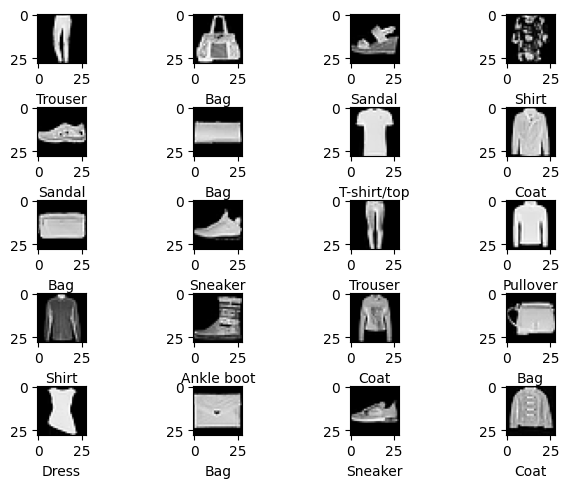

In [185]:
#plot_samples(5, 4, torch.randint(0, len(train_data), (1,1)).item())
plot_random_samples(5, 4, train_data)

In [186]:
print(len(train_data))

60000


# Dataloader
Prepare the dataloader

In [190]:
g = torch.Generator(device=device)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_data,
    batch_size=32,
    shuffle=True,
    generator=g
)

In [191]:
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=32,
    shuffle=True,
    generator=g
)

In [192]:
print(next(iter(train_dataloader)))

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        ...,


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0

In [193]:
ls = [0, 1, 2, 3, 4, 5]
print(ls)
print(iter(ls))
print(next(iter(ls)))
print(next(iter(ls)))

ls_iter = iter(ls)
print(next(ls_iter))
print(next(ls_iter))
print(next(ls_iter))
print(next(ls_iter))
print(next(ls_iter))

[0, 1, 2, 3, 4, 5]
0
0
0
1
2
3
4


In [194]:
batch_inputs, batch_labels = next(iter(train_dataloader)) 
print(batch_inputs.shape) #A batch of 32 inputs, 1 color channel and 28 by28 images
print(batch_labels.shape) #1 image per batch, meaning there's a total of {batch_size} labels
print(len(train_dataloader)) #How many batches there is in the dataloader

torch.Size([32, 1, 28, 28])
torch.Size([32])
1875


## Baseline model

In [195]:
#nn.Flatten flattens the image in this case, very simillarly to .view()

class CVModel(nn.Module):
    def __init__(self, px, n_classes):
        super().__init__()
        
        self.act_fn = nn.ReLU()
        self.flat = nn.Flatten()
        self.linear1 = nn.Linear(in_features=px*px, out_features=8*8)
        self.linear2 = nn.Linear(in_features=8*8, out_features=n_classes)
    
    def forward(self, x):
        flattened = self.flat(x) #squeeze to remove the color channels
        linear1 = self.linear1(flattened)
        nonlinear1 = self.act_fn(linear1)

        linear2 = self.linear2(nonlinear1)

        return linear2



In [214]:
from tqdm import tqdm
model = CVModel(28, 10)
model.to(device)
loss_fn = nn.CrossEntropyLoss()


In [217]:
#Traning loop

optimizer = torch.optim.AdamW(params=model.parameters(), lr=0.01)
epochs = 5

model.train()
for epoch in range(epochs):
    for inputs_batch, labels_batch in tqdm(train_dataloader):
        logits = model(inputs_batch.to("cuda"))
        loss = loss_fn(logits, labels_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

print(loss)


100%|██████████| 1875/1875 [00:08<00:00, 230.64it/s]

tensor(0.2734, device='cuda:0', grad_fn=<NllLossBackward0>)


In [179]:

def calc_acc(y_preds, y_labels):
    acc = torch.div(toch.eq(y_preds, y_labels).sum(), len(y_labels))
    return acc






# Building a CNN

also knowns as convNets
or convolutional neural networks

In [219]:
class ConvNN(nn.Module):
    def __init__(self, input_shape):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=8*8,
                kernel_size=(3,3),
                stride=1,
                padding=1),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=8*8,
                out_channels=8*8,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d()
        )